# Sparkify Project: Predicting Customer Churn
In this workspace there will be several steps peformed to build and evaluate a model predicting customer churn:
    
   1. [Load and Clean Dataset](#preprocess)
   2. [Exploratory Data Analysis](#analysis)
   3. [Feature Engineering](#features)
   4. [Modeling](#model)
   5. [Conclusion](#conclusion)
   
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

In [14]:
#Importing Libraries
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, countDistinct
from pyspark.sql.functions import isnull, when, count, col, isnan
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, GBTClassifier, DecisionTreeClassifier,LogisticRegression,RandomForestClassifier

In [15]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset <a id='preprocess'></a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 
Load and clean the dataset, checking for invalid or missing data, in this case records without userids or sessionids. 

In [16]:
#Load json file
data= spark.read.json('./mini_sparkify_event_data.json')

In [17]:
#explore data set
data.head(5)
data.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [18]:
# check number of rows in dataset
data.count()

286500

In [19]:
# check dataset for nan and missing values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There are no missing or nan values in the columns of interest, which in this case are sessionId and userId.
The only missing values are in columns that are not relevant for the further analysis, are nor needed in the notebook.
Although there are no missing values in the next few cells i will provide code to drop all the columns that have missing userId or session Id in case the notebook is used with the full dataset.

In [20]:
data = data.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [21]:
# drop empty userId columns
data = data.filter(data['userId'] != '')

In [22]:
# check missing values in userId column
data.filter((data["userId"] == "")| data["userId"].isNull() | isnan(data["userId"])).count()

0

In [23]:
# check missing values in sessionId column
data.filter((data["sessionId"] == "") | data["sessionId"].isNull() | isnan(data["sessionId"])).count()

0

# Exploratory Data Analysis <a id='analysis'></a>
In this workspace, a small subset of the whole dataset is explored.

### Define Churn

A column `Churn` is created to use as the label for the ML model. I used the `Cancellation Confirmation` events to define churn, which happens for both paid and free users.

### Explore Data
I performed some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [24]:
#create a Churn Column 
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
data = data.withColumn('Churn', churn('page'))

In [25]:
# create a datetime column from timestamp
timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
data = data.withColumn("time", timestamp(data.ts))
data = data.withColumn('registration_time',timestamp('registration'))

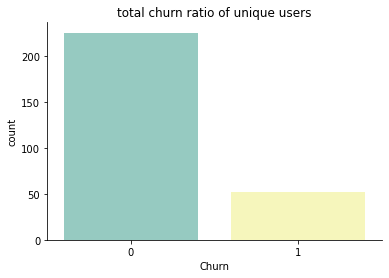

In [26]:
# plot churn distribution for unique users
churn_bar = data.dropDuplicates(["userId", "Churn"]).groupby(["Churn"]).count().sort("Churn").toPandas()
ax=sns.barplot(x='Churn', y='count', data=churn_bar,palette='Set3')
plt.xlabel('Churn')
plt.ylabel('count')
plt.title('total churn ratio of unique users')
sns.despine(ax=ax);
plt.savefig('total churn ratio')

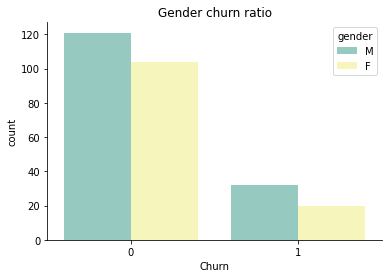

In [27]:
# plot male and female churn ratio
gender_churn = data.dropDuplicates(["userId", "gender",'Churn']).groupby(["Churn",'gender']).count().sort("Churn").toPandas()
ax=sns.barplot(x='Churn', y='count', hue='gender',data=gender_churn, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('count')
plt.title('Gender churn ratio')
sns.despine(ax=ax);
plt.savefig('gender churn ratio')

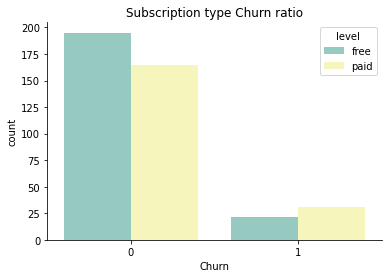

In [28]:
# plot paid and free subscription churn ratio
subscription_churn = data.dropDuplicates(["userId", "level",'Churn']).groupby(["Churn",'level']).count().sort("Churn").toPandas()
ax=sns.barplot(x="Churn", y="count",hue='level', data=subscription_churn, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('count')
plt.title('Subscription type Churn ratio')
sns.despine(ax=ax);
plt.savefig('subscription type churn ratio')

In [29]:
# plot time since registration -> at what point of time do customers churn?
lifetime = data.select('userId','registration','ts','Churn').withColumn('lifetime',(data.ts-data.registration)) \
    .groupBy('userId','Churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'Churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

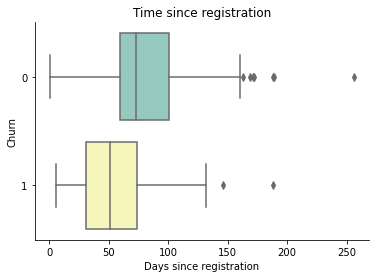

In [30]:
ax = sns.boxplot(data=lifetime, y='Churn', x='lifetime', orient='h', palette='Set3')
plt.xlabel('Days since registration')
plt.ylabel('Churn')
plt.title('Time since registration')
sns.despine(ax=ax);
plt.savefig('time since registration')

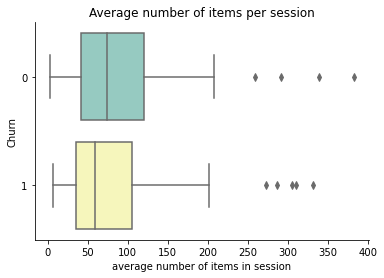

In [31]:
# plot average number of items per session
items = data \
    .select('userId','itemInSession','Churn') \
    .groupBy('userId','Churn') \
    .agg({'itemInSession':'avg'}) \
    .withColumnRenamed('avg(itemInSession)','itemInSession') \
    .select('userId', 'Churn', (col('itemInSession')).alias('itemInSession')) \
    .toPandas()
ax = sns.boxplot(data=items, y='Churn', x='itemInSession', orient='h', palette='Set3')
plt.xlabel('average number of items in session')
plt.ylabel('Churn')
plt.title('Average number of items per session')
sns.despine(ax=ax);
plt.savefig('avg items per session')

# Feature Engineering <a id='features'></a>
I build out the featuresi found promising to train the model on.

I extracted features based on the small subset of data.

In [32]:
# feature 1: days since registration
feature_1 = data \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(data.ts-data.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('registration_days'))
feature_1.describe().show()
feature_1.show(5)

+-------+------------------+-------------------+
|summary|            userId|  registration_days|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+

+------+------------------+
|userId| registration_days|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [33]:
# feature 2: number of items per session
feature_2 = data.select('userId','itemInSession').groupBy('userId').agg({'itemInSession':'avg'}).withColumnRenamed('avg(itemInSession)','itemInSession').select('userId', (col('itemInSession')).alias('items_per_session'))
feature_2.describe().show()
feature_2.show(5)

+-------+------------------+------------------+
|summary|            userId| items_per_session|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 85.26612937155095|
| stddev|105396.47791907164|58.099810332288286|
|    min|                10|               2.5|
|    max|                99| 383.1247511612475|
+-------+------------------+------------------+

+------+------------------+
|userId| items_per_session|
+------+------------------+
|100010| 35.89501312335958|
|200002| 60.57805907172996|
|   125|               5.0|
|    51|200.60349025974025|
|   124|165.09927461139895|
+------+------------------+
only showing top 5 rows



In [34]:
# feature 3: user level
feature_3 = data.dropDuplicates(['userId']).select(['userId','level']).replace(['paid','free'], ['1', '0'])
feature_3 = feature_3.withColumn('level', feature_3.level.cast("float"))
feature_3.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|  0.0|
|200002|  0.0|
|   125|  0.0|
|   124|  1.0|
|    51|  1.0|
+------+-----+
only showing top 5 rows



In [35]:
# feature 4: number of thumbs up
feature_4 = data.select('userId', 'page').where(data.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'thumbs_up')
feature_4.show(5)

# feature 5: number of thumbs down
feature_5 = data.select('userId', 'page').where(data.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'thumbs_down')
feature_5.show(5)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows



In [36]:
# feature 6: number of sessions
feature_6 = data.select("userId", "sessionId").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "number_of_sessions")
feature_6.show(5)

+------+------------------+
|userId|number_of_sessions|
+------+------------------+
|100010|                 7|
|200002|                 6|
|   125|                 1|
|    51|                10|
|   124|                29|
+------+------------------+
only showing top 5 rows



In [37]:
# feature 7: gender
feature_7 = data.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
feature_7.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



In [38]:
# feature 8: total time in service
feature_8 = data.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')
feature_8.show(5)

+------+------------------+
|userId|        total_time|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



In [39]:
# feature 9: number of songs added to playlist
feature_9 = data.select('userID','page').where(data.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'songs_playlist')
feature_9.show(5)

+------+--------------+
|userID|songs_playlist|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
+------+--------------+
only showing top 5 rows



In [40]:
# feature 10: number of friends added
feature_10 = data.select('userID','page').where(data.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'friends')
feature_10.show(5)

+------+-------+
|userID|friends|
+------+-------+
|100010|      4|
|200002|      4|
|    51|     28|
|   124|     74|
|     7|      1|
+------+-------+
only showing top 5 rows



In [41]:
# Churn label (response variable)
label = data.select('userId', 'Churn').dropDuplicates().withColumnRenamed('Churn', 'label')
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|    73|    0|
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
+------+-----+
only showing top 5 rows



In [42]:
data_features = feature_1.join(feature_2, 'userId', 'inner').join(feature_3, 'userId', 'inner').join(feature_4, 'userId', 'inner')\
             .join(feature_5, 'userId', 'inner').join(feature_6, 'userId', 'inner').join(feature_7, 'userId', 'inner')\
             .join(feature_8, 'userId', 'inner').join(feature_9, 'userId', 'inner').join(feature_10, 'userId', 'inner').join(label,'userId','inner').drop("userId")

data_features.show(5)

+------------------+------------------+-----+---------+-----------+------------------+------+------------------+--------------+-------+-----+
| registration_days| items_per_session|level|thumbs_up|thumbs_down|number_of_sessions|gender|        total_time|songs_playlist|friends|label|
+------------------+------------------+-----+---------+-----------+------------------+------+------------------+--------------+-------+-----+
|  55.6436574074074| 35.89501312335958|  0.0|       17|          5|                 7|     0|       66940.89735|             7|      4|    0|
| 70.07462962962963| 60.57805907172996|  0.0|       21|          6|                 6|     1| 94008.87593999993|             8|      4|    0|
|131.55591435185184|165.09927461139895|  1.0|      171|         41|                29|     0|1012312.0927900008|           118|     74|    0|
|19.455844907407407|200.60349025974025|  1.0|      100|         21|                10|     1| 523275.8428000004|            52|     28|    1|
|19.45

# Modeling <a id='model'></a>
The dataset was split into train, test, and validation sets. 

5 ML models were trained and evaluated based on test accuracy.
The winner model was then used to perform hyperparameter tuning. The final results were reported based on the validation set. Here the f1 score was used as metric to optimize, since the churned users are a fairly small subset.


### Metrics

For the evaluation i used the f1 score and accuracy. The f1 score is a measure of precision (sending the offer to the right person) and recall (missing users that we should have send an offer). The accuracy is a measure of how well we categorized the users in the two relevant classes ('churn' and 'non-churn').
Both help us adress the offers/incentives only to users that are likely to churn and help prevent sending offers to users, that aren't likely to churn. Sending out offers to these would mean wasting money because also without the offer they wouldn't want to churn.

In [43]:
def model_train_and_evaluate(df,classification_model,model_name):
    '''
    function to perform 
        1.vectorization, normalization of a dataframe, 
        2.training given classification model
        3.evaluating the models performance
    
    args:
        df: dataframe with features and label
        classification_model: spark classification model used for prediction
        model_name: name of the classification model'''
    
    # splitting dataset into train, test and validation data
    train, rest = df.randomSplit([0.6, 0.4], seed=12)
    validation, test = rest.randomSplit([0.5, 0.5], seed=12)
    
    # initialize vectorizer
    assembler = VectorAssembler(inputCols=['registration_days','items_per_session','level','thumbs_up','thumbs_down','number_of_sessions','gender','total_time','songs_playlist','friends'], outputCol="NumFeatures")
    # initialize normalizer
    scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
    
    # build pipeline with vectorizer, normalizer and classification_model
    pipeline=Pipeline(stages=[assembler,scaler,classification_model])

    # fit pipeline on training data
    pmodel=pipeline.fit(train)
    
    # predicting on test data
    results=pmodel.transform(test)
    
    #initialize evaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    #evaluate model on accuracy and f1 Score and print results
    print(model_name)
    print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
    print('f1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))
    

In [44]:
# Model training and evaluation of logistic regression
logreg=LogisticRegression()
model_train_and_evaluate(data_features,logreg,'Logistic Regression:')

Logistic Regression:
Accuracy: 0.8732394366197183
f1 Score:0.8141480461717674


In [45]:
# Model training and evaluation of linear support vector machine
lsvc = LinearSVC()
model_train_and_evaluate(data_features,lsvc,'Linear Support Vector Machine:')

Linear Support Vector Machine:
Accuracy: 0.8732394366197183
f1 Score:0.8141480461717674


In [46]:
# Model training and evaluation of decision tree classifier
dt = DecisionTreeClassifier()
model_train_and_evaluate(data_features,dt,'Decision Tree:')

Decision Tree:
Accuracy: 0.8169014084507042
f1 Score:0.8007541310857268


In [47]:
# Model training and evaluation of gradient boostet tree
gbt = GBTClassifier(seed=42)
model_train_and_evaluate(data_features,gbt,'Gradient Boostet Tree:')

Gradient Boostet Tree:
Accuracy: 0.7605633802816901
f1 Score:0.7658910243661369


In [48]:
# Model training and evaluation of random forest classfier
rf = RandomForestClassifier(numTrees=10)
model_train_and_evaluate(data_features,rf,'Random Forest Classifier:')

Random Forest Classifier:
Accuracy: 0.7887323943661971
f1 Score:0.7833637116818558


#### Model summary: <a id='model_summary'></a>
* The logistic regression model has a accuracy of: 0.873, and F1 score of:0.814
* The linear support vector machine model has a accuracy of: 0.873, and F1 score of:0.814
* The decision tree model has a accuracy of: 0.817, and F1 score of:0.801
* The gradient boosted tree model has a accuracy of: 0.761, and F1 score of:0.769
* The random forest model has a accuracy of: 0.789, and F1 score of:0.783

#### Tuning Hyperparameters

Regarding the accuracy of the test set the model of choice is Logistic Regression.
Therefore it is used to tune the hyperparameters using GridSearch/Cross Validation.
The hyperparameters tuned in this section are: `threshold` and `maxIter`, maximum number of iterations.
The default values were: `maxIter=10`, `threshold=0.5` .
The tested values using GridSearch will be: 
    `threshold`: 0.3, 0.4, 0.5
    `maxIter`:   0, 50, 100

In [80]:
# splitting dataset into train, test and validation data
train, rest = data_features.randomSplit([0.6, 0.4], seed=12)
test, validation = rest.randomSplit([0.5, 0.5], seed=12)

# initialize vectorizer
assembler = VectorAssembler(inputCols=['registration_days','items_per_session','level','thumbs_up','thumbs_down','number_of_sessions','gender','total_time','songs_playlist','friends'], outputCol="NumFeatures")
# initialize normalizer
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
# inititalize classifier
logreg= LogisticRegression()

# build pipeline
pipeline=Pipeline(stages=[assembler,scaler,logreg])

# initialize evaluater
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# initialize paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(logreg.threshold,[0.3,0.4,0.5]) \
    .addGrid(logreg.maxIter,[0,50,100])\
    .build()

# perform cross validation
crossval = CrossValidator(estimator=pipeline,
                          evaluator=f1_score, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)
#fit training data on cross validator
pmodel=crossval.fit(train)
print(pmodel.avgMetrics)
print(pmodel.extractParamMap)

#predcit on validation data
results=pmodel.transform(validation)

#initialize evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('final Linear SVC metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))


[0.7508743369443893, 0.7427643035179001, 0.7427643035179001, 0.7508743369443893, 0.7508743369443893, 0.7468713076249043, 0.7508743369443893, 0.7508743369443893, 0.7508743369443893]
<bound method Params.extractParamMap of CrossValidatorModel_2edce57334db>
final Linear SVC metrics:
Accuracy: 0.8732394366197183
F-1 Score:0.8141480461717674


In [82]:
# show the hyperparameters of the best model
pmodel.getEstimatorParamMaps()[np.argmax(pmodel.avgMetrics) ]

{Param(parent='LogisticRegression_d45f9232b610', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.3,
 Param(parent='LogisticRegression_d45f9232b610', name='maxIter', doc='max number of iterations (>= 0).'): 0}

The best model params are: `maxIter = 0` `threshold = 0.3`
The analysis shows that the maxIter parameters had no influence on the outcome of the CrossValidation but the threshold improved the model performance when set to 0.3 instead of 0.5.

# Conclusion <a id='conclusion'></a>

## Summary
In this notebook we build a model for predicting customer churn.
Several steps were performed using the mini sparkify dataset:
    1. Load dataset
    2. Clean dataset removing rows with Nan or missing values
    3. Exploring dataset
    4. Feature Extraction: Extracting features from the dataset for predicting customer churn
    5. Model Building and Evaluation: Building of several ML pipelines using different Classifiers, Evaluating Models
    6. Tuning hyperparameters of model, that had the highest accuracy on test set and improve f1 score using cross validation

## Results

In this notebook a spark environment is used to analyze a dataset. This gives us the opportunity to perform the analysis on a bigger dataset which needs more capacity and can usually not be performed on a single local machine.
Examine and predicting customer churn is an essential method for companies to prevent losing users.
This notebook shows that the main task is finding the right features to predict churn. It is crucial for implementing and improving the model.

For the evaluation i used the f1 score and accuracy. The f1 score is a measure of precision (sending the offer to the right person) and recall (missing users that we should have send an offer). The accuracy is a measure of how well we categorized the users in the two relevant classes ('churn' and 'non-churn').
Both help us adress the offers/incentives only to users that are likely to churn and help prevent sending offers to users, that aren't likely to churn. Sending out offers to these would mean wasting money because also without the offer they wouldn't want to churn.

For the features I´ve chosen i got the following model performances:
    
The classifier, that performed best on test set (regarding accuracy) was Logistic Regression.
The tuning of hyperparameters in that model only showed minimal improvements of f1 scores. 
* The logistic regression model has a accuracy of: 0.873, and F1 score of:0.814
* The linear support vector machine model has a accuracy of: 0.873, and F1 score of:0.814
* The decision tree model has a accuracy of: 0.817, and F1 score of:0.801
* The gradient boosted tree model has a accuracy of: 0.761, and F1 score of:0.769
* The random forest model has a accuracy of: 0.789, and F1 score of:0.783

The model performance of logistic regression and linear SVM had a higher accuracy and f1 score. This might be due to the simplicity of the model and that we only used very few features.
Since both models are limited when it comes to predicting complex models (i.e. when implementing new features) chosing GBT classifier, Decision Tree or Random Forest might lead to improved results.

As a final step hyperparameter tuning was performeds. The parameters `threshold` and `maxIter`of the Logistic Regression Model were tuned using paramGrid and crossVal and improving f1 score. The final parameters were: `threshold= 0.5` and `maxIter= 0` which led to the following model performance measured on the validation testset: f1-Score= 0.814  accuracy= 0.873.


## Improvements
For improving the model i would suggest several steps:
* put additional effort in feature engineering (more time series analysis) and implement new features
* perform PCA on features to improve model run time
* perform analysis on a larger dataset (the analyzed churn rate was quite low)

